In [1]:
%run init_notebook.py

In [2]:
from settings import DATA_DIR, GRAPHS_DIR

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import eurostat

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime

import os

In [4]:
start, end = datetime(2015, 1, 1), datetime(2023, 12, 31)

In [5]:
_deI = pd.read_excel(os.path.join(DATA_DIR, 'bund_inflation.xlsx'), sheet_name='DE0001030575')
_deB = pd.read_excel(os.path.join(DATA_DIR, 'bund_inflation.xlsx'), sheet_name='DE0001102341')

bei_de = pd.concat([_deI.set_index('Date')['Close'].rename('10yI'), _deB.set_index('Date')['Close'].rename('10yB')], axis=1).sort_index()
bei_de.index.rename('date', inplace=True)

# bei_de['bei_de'] = bei_de['10yI'] - bei_de['10yB']
bei_de['bei_de'] = (0.025 / bei_de['10yB'] - 0.00122 / bei_de['10yI'])

bei_fr = pd.read_excel(os.path.join(DATA_DIR, 'break_even_inflation.xls'), skiprows=5)
bei_fr.set_index('Unnamed: 0', inplace=True)
bei_fr.index.rename('date', inplace=True)
bei_fr.columns = ['OAT', 'OATI', 'bei_fr']

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\LukasGrahl\\Documents\\GIT\\memoire2\\data\\break_even_inflation.xls'

In [6]:
bei = bei_fr.join(bei_de, how='outer')[['bei_de', 'bei_fr']].dropna()

## eurostat

In [ ]:
codes = eurostat.get_toc_df()

[i for i in codes['title'] if 'gdp'.lower() in i.lower()];

In [32]:
codes[codes.title == 'Gross domestic product (GDP) at market prices - quarterly data']

,title,code,type,last update of data,last table structure change,data start,data end
1292,Gross domestic product (GDP) at market prices ...,TIPSAU20,dataset,2023-11-15T11:00:00+0100,2023-11-15T11:00:00+0100,1995-Q1,2023-Q3


In [8]:
data = eurostat.get_data('prc_hicp_midx', filter_pars={'geo': ['DE','FR']})

## CPI analysis

In [9]:
df = pd.DataFrame(data[1:], columns=data[0]).transpose()
df = df.loc[:, (df.loc['unit'] == 'I05') & (df.loc['coicop'] == 'CP00')]
df.columns = [f'cpi_{i}' for i in df.loc['geo\TIME_PERIOD'].values]

cpi = df.iloc[5:].copy().dropna().astype(float)
cpi.index = [datetime(int(i[:4]), int(i[5:7]), 1) for i in cpi.index]

<Axes: >

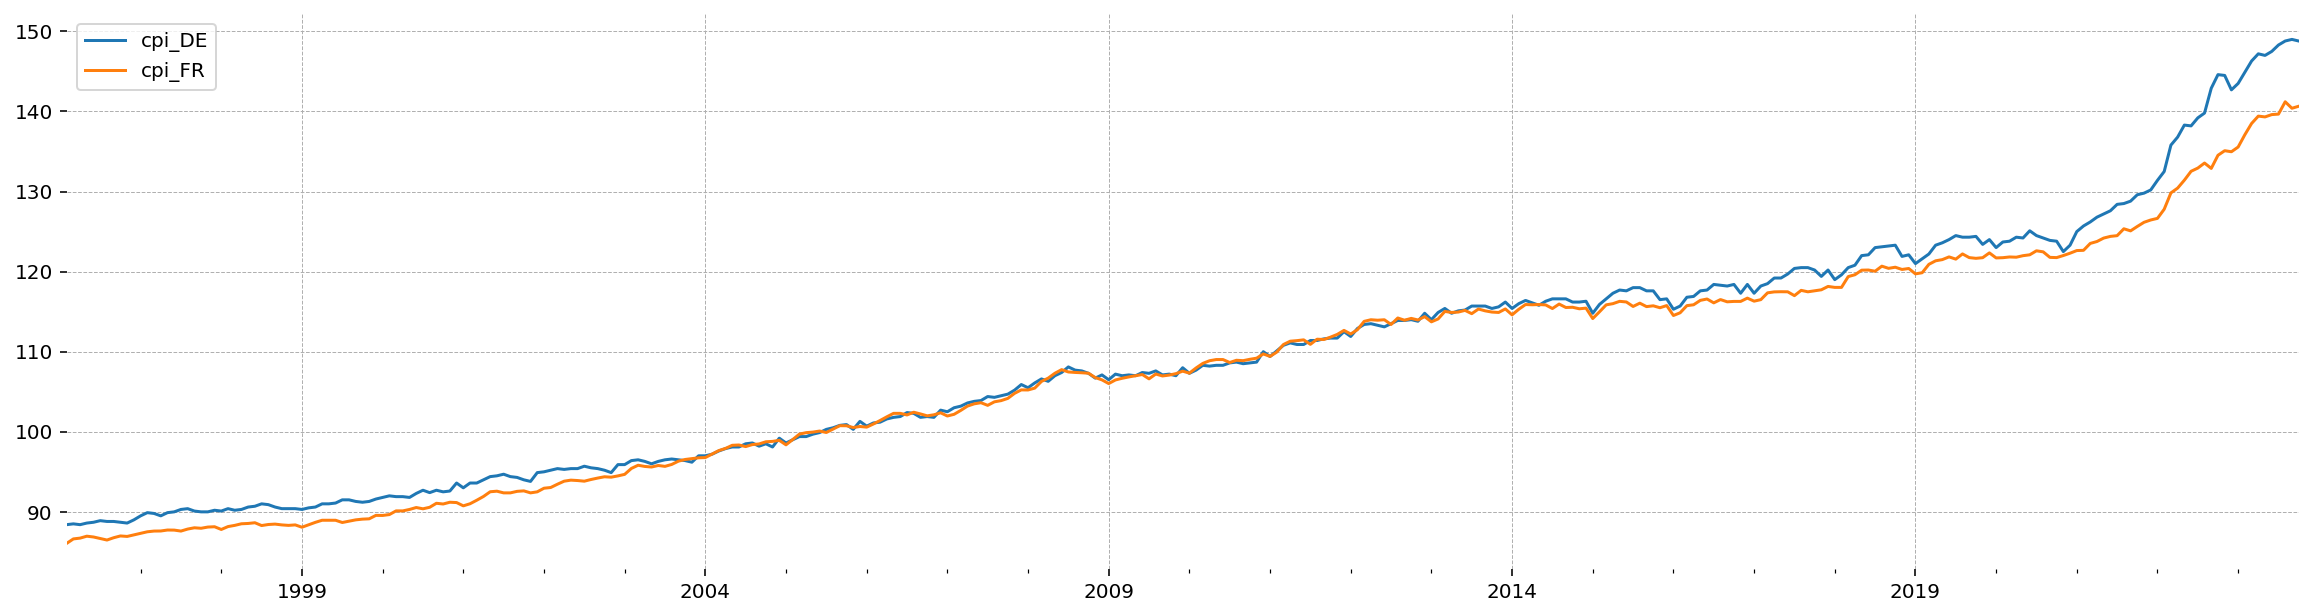

In [10]:
cpi.plot(figsize=(20,5))

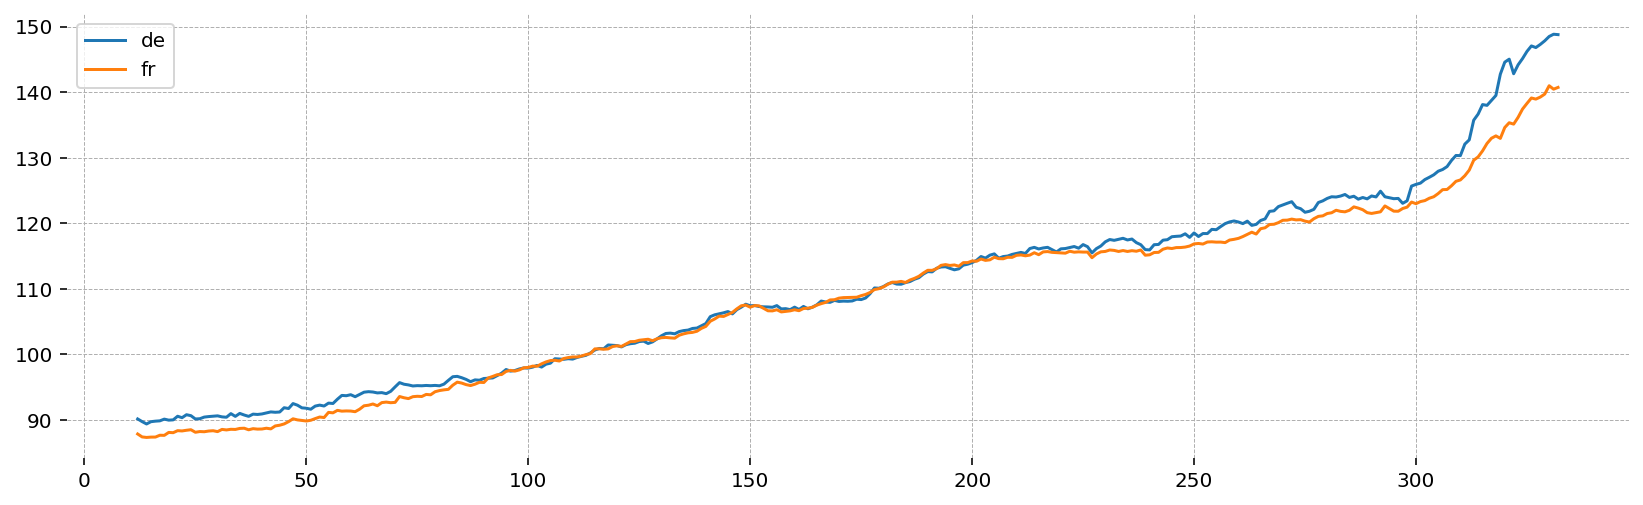

In [11]:
sd_de = seasonal_decompose(cpi.cpi_DE.values, period=12, two_sided=False)
cpi['cpi_DE_sd'] = sd_de.trend + sd_de.resid

sd_fr = seasonal_decompose(cpi.cpi_FR.values, period=12, two_sided=False)
cpi['cpi_FR_sd'] = sd_fr.trend + sd_fr.resid

plt.plot(sd_de.resid + sd_de.trend)
plt.plot(sd_fr.resid + sd_fr.trend)
plt.legend(['de', 'fr'])

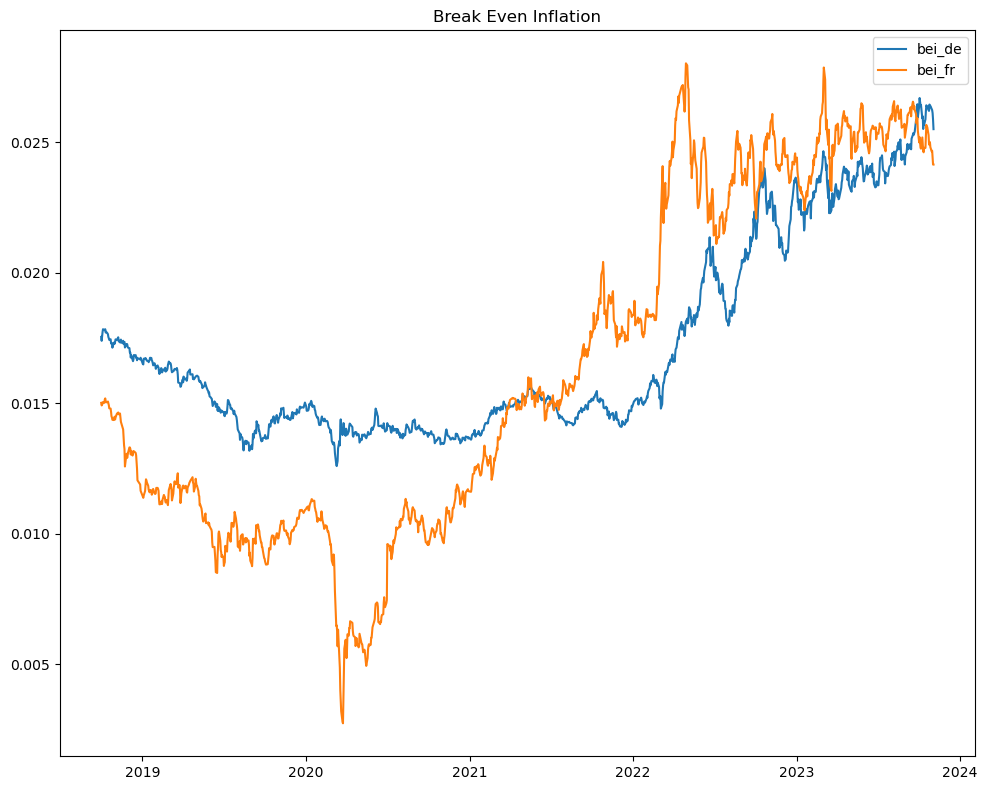

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.plot(bei)
plt.legend(bei.columns)
plt.title('Break Even Inflation')

plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'bei_fig.png'))

# pi

In [77]:
country = 'DE'
df = bei[[f'bei_{country.lower()}']].join(cpi[[f'cpi_{country}_sd']], how='inner').dropna().copy()

In [16]:
save = input('save y/n')
if save.lower() == 'y':
    with open(os.path.join(GRAPHS_DIR, f'{country}_describe.tex'), 'w') as tf:
        _ = df.copy()
        _.columns = ['BEI', 'CPI']
        tf.write(
            _.describe().to_latex(formatters={"name": str.upper}, float_format="{:.1f}".format)
        )

    with open(os.path.join(GRAPHS_DIR, f'{country}_corr.tex'), 'w') as tf:
        _ = df.copy()
        _.columns = ['BEI', 'CPI']
        tf.write(
            _.corr().to_latex(formatters={"name": str.upper}, float_format="{:.1f}".format, )
        )

save y/n n


In [78]:
df_diff = np.log(df).diff().dropna().copy()
df = df.apply(lambda x: (x - x.mean()) / x.std())

In [80]:
bei

,bei_de,bei_fr
date,,
2018-10-01,0.017547,0.01502
2018-10-02,0.017396,0.01492
2018-10-04,0.017731,0.01499
2018-10-05,0.017840,0.01505
2018-10-08,0.017809,0.01502
...,...,...
2023-10-30,0.026275,0.02465
2023-10-31,0.026237,0.02468
2023-11-01,0.026123,0.02442


In [81]:
save = input('save y/n')
if save.lower() == 'y':
    with open(os.path.join(GRAPHS_DIR, f'cpi_describe.tex'), 'w') as tf:
        _ = np.log(cpi).diff()[['cpi_DE_sd']].copy()
        _.columns = ['CPI']
        _ = _.describe()
        _ = _.drop(['25%', '50%', '75%'], axis=0)
        tf.write(
            _.to_latex(formatters={"name": str.upper}, float_format="{:.4f}".format)
        )
        
    with open(os.path.join(GRAPHS_DIR, f'bei_describe.tex'), 'w') as tf:
        _ = np.log(bei).diff()[['bei_de']].copy()
        _.columns = ['BEI']
        _ = _.describe()
        _ = _.drop(['25%', '50%', '75%'], axis=0)
        tf.write(
            _.to_latex(formatters={"name": str.upper}, float_format="{:.4f}".format)
        )

save y/n y


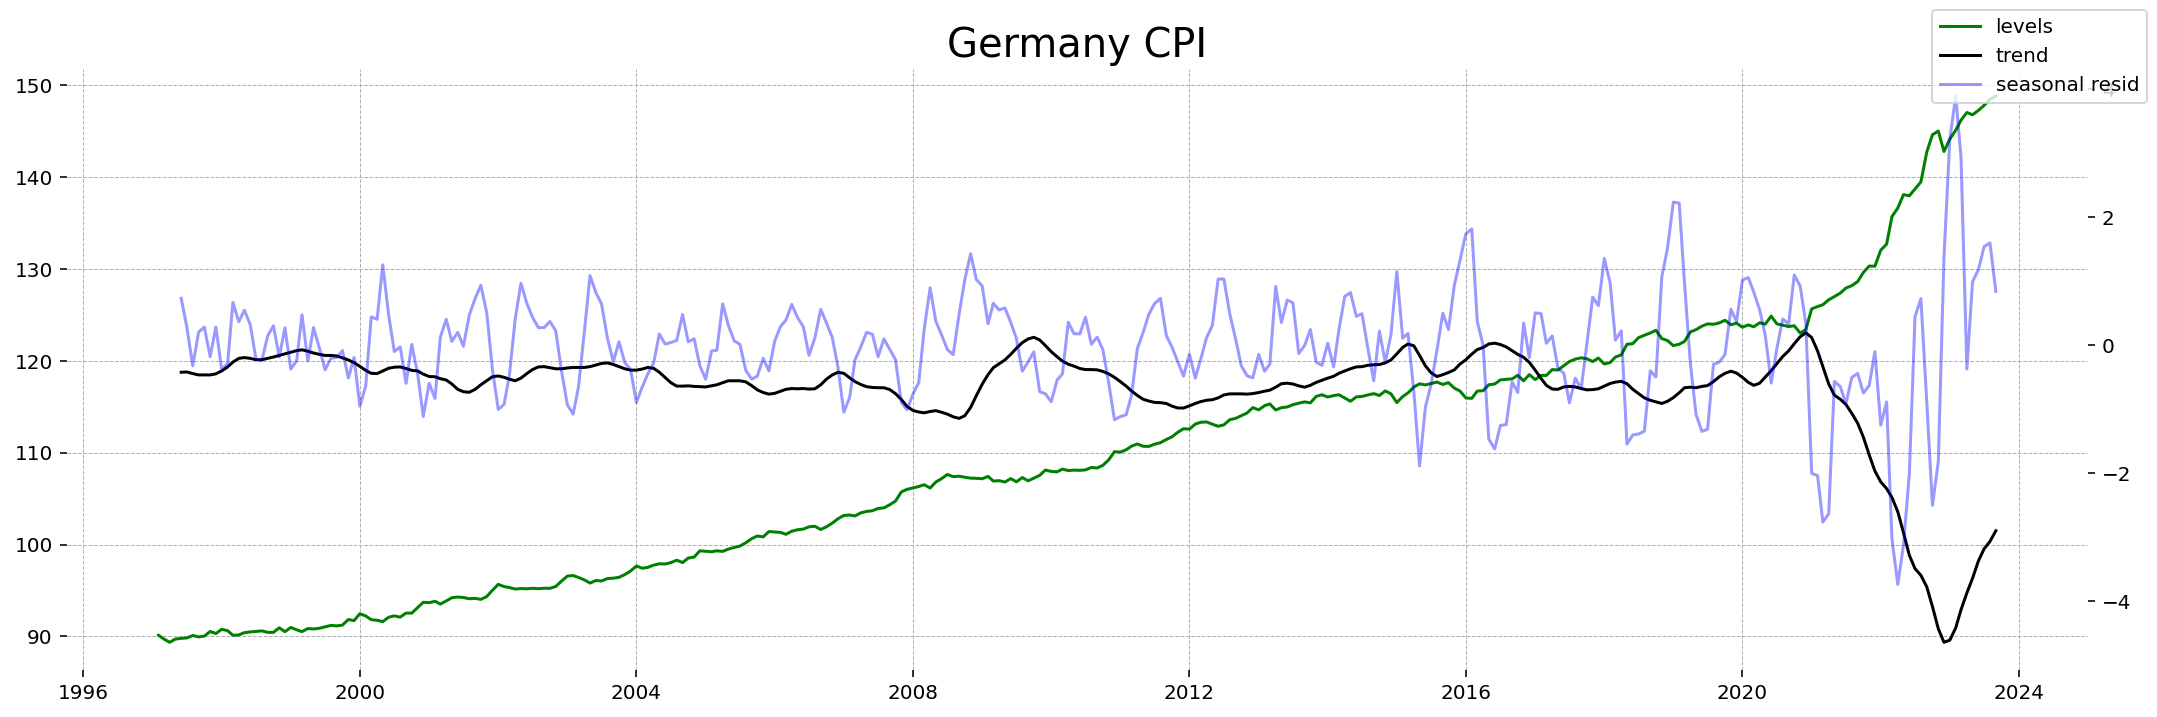

In [153]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(cpi.cpi_DE_sd, color='green', label='levels')

ax2 = ax.twinx()
ax2.grid(False)

x = (cpi.cpi_DE.shift(4) - cpi.cpi_DE).dropna()
sd = seasonal_decompose(x, period=12, two_sided=False)
ax2.plot(sd.trend, color='black', label='trend')
ax2.plot(sd.resid, color='blue', alpha=.4, label='seasonal resid')

ax.set_title('Germany CPI', size=20)
fig.legend();

plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'de_cpi.png'))

In [154]:
from src.time_ser import adf_test_summary

In [156]:
adf_test_summary(sd.resid.dropna())

-----------------------------------------------------------------------------
ADF Test RESID: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  #lags   #obs     1%     5%    10%
constant                  -4.242    0.001   16.0  299.0 -3.452 -2.871 -2.572
constant trend            -4.184    0.005   16.0  299.0 -3.989 -3.425 -3.136
constant ltend, qtrend    -4.173    0.019   16.0  299.0 -4.410 -3.852 -3.566
none                      -4.208    0.000   16.0  299.0 -2.573 -1.942 -1.616




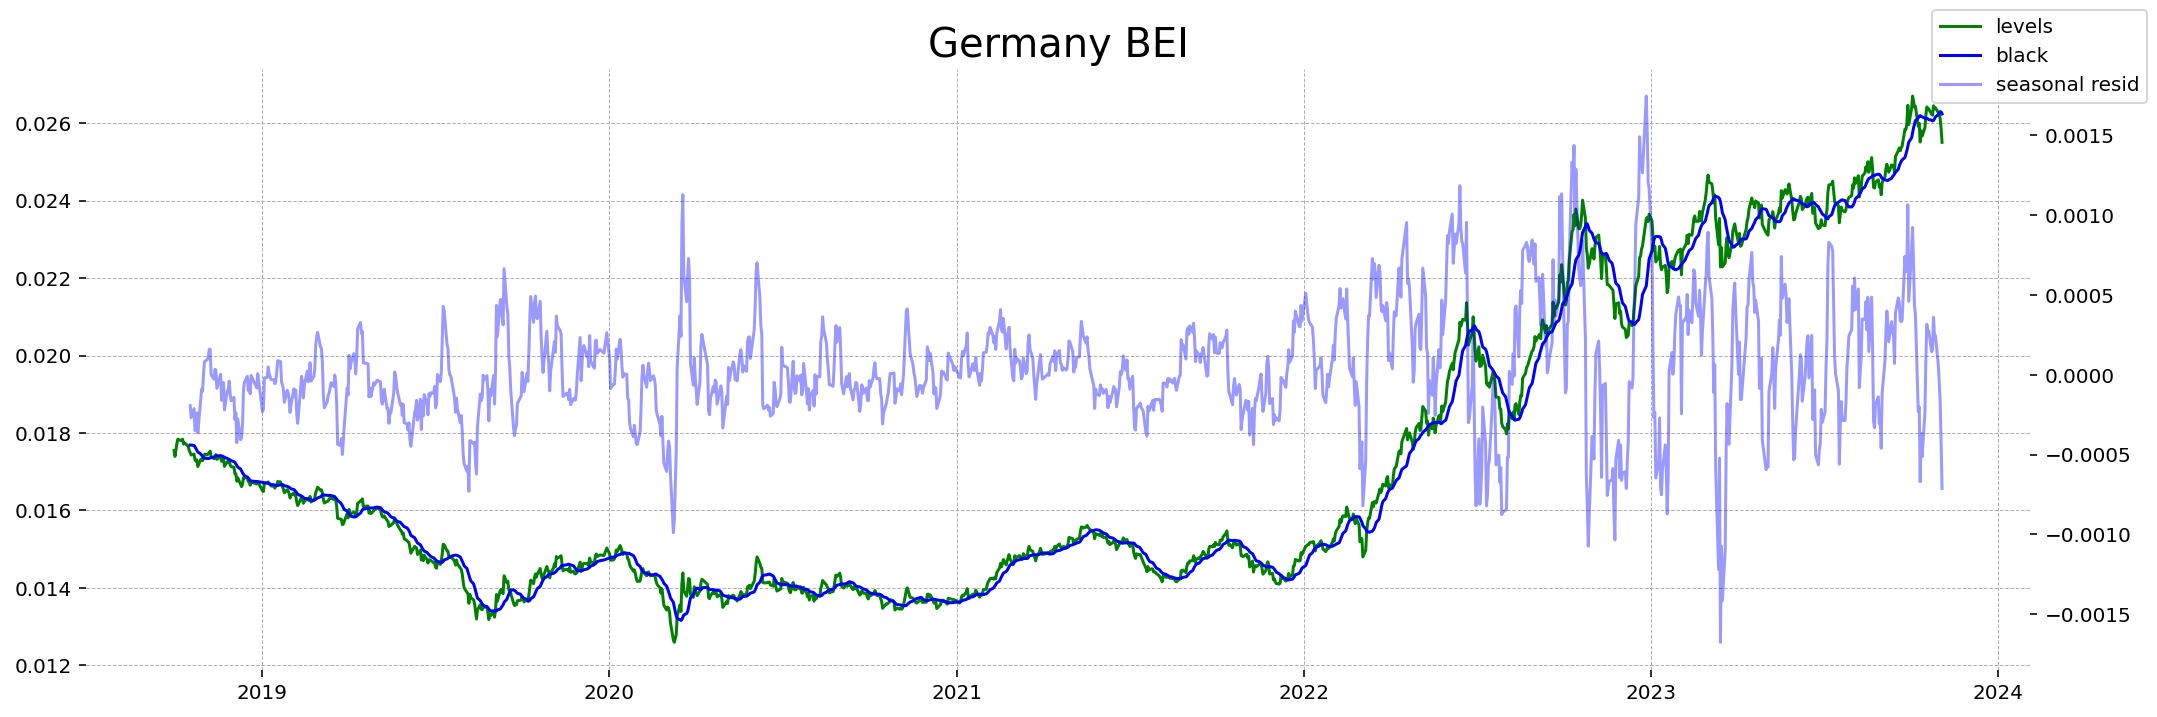

In [152]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(bei.bei_de, color='green', label='levels')

ax2 = ax.twinx()
ax2.grid(False)

sd = seasonal_decompose(bei.bei_de, period=12, two_sided=False)
ax.plot(sd.trend, color='blue', label='black')
ax2.plot(sd.resid, color='blue', alpha=.4, label='seasonal resid')

# ax2.plot(np.log(bei).diff().bei_de, color='blue', alpha=.4, label='log return')

ax.set_title('Germany BEI', size=20)
fig.legend();

plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'de_bei.png'))

<Axes: >

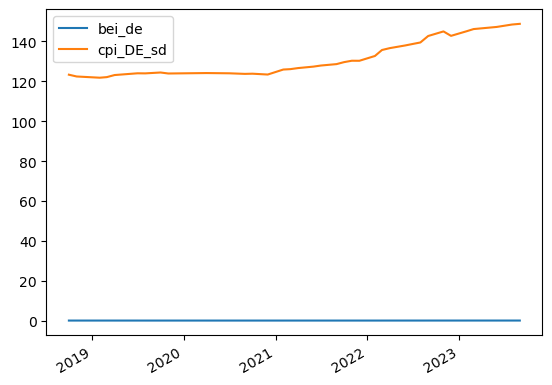

In [21]:
df.plot()

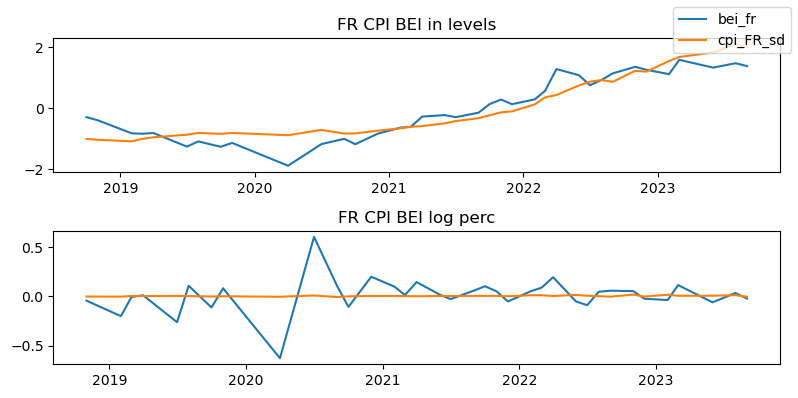

In [17]:
fig, ax = plt.subplots(2,1, figsize=(8, 4))

ax[0].plot(df)
ax[1].plot(df_diff)

ax[0].set_title(f'{country} CPI BEI in levels')
ax[1].set_title(f'{country} CPI BEI log perc')

fig.legend(df.columns)
plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, f'{country}_fig.png'))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 5))

ax[0].plot(df_pi.dropna()[['bei_de']], color='red', label='BEI')
ax[1].plot(np.log(df_pi).diff().dropna()[['bei_de']], color='red', label='BEI')

ax12 = ax[0].twinx()
ax22 = ax[1].twinx()

ax12.plot(df_pi.dropna()[['cpi_DE_filt']], color='green', label='CPI deseasonal')
ax12.plot(np.log(df_pi).diff().dropna()[['cpi_DE']], color='blue', label='CPI')

ax22.plot(df_pi.diff().dropna()[['cpi_DE_filt']], color='green', label='CPI deseasonal')
ax22.plot(np.log(df_pi).diff().dropna()[['cpi_DE']], color='blue', label='CPI')

ax[0].set_title('Germany BEI, CPI in levels')
ax[1].set_title('Germany BEI, CPI difference')

fig.legend()

plt.tight_layout()

## pymc

In [93]:
import scipy

In [114]:
np.arange(10) / 2

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [123]:
np.arange(100) / 100

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [130]:
365 / 30

12.166666666666666

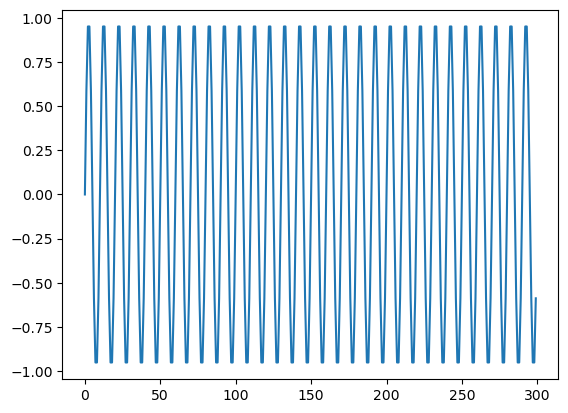

In [133]:
plt.plot( np.sin( 2 * np.pi * np.arange(N) / 30 * f_order ) )

In [226]:
N = 365
trend = .05
sigma = 2
f_order = 2
season_int = 30

ser = np.arange(N) * trend + np.sin( 2 * np.pi * np.arange(N) / season_int * f_order )  + scipy.stats.norm(0, sigma).rvs(N)

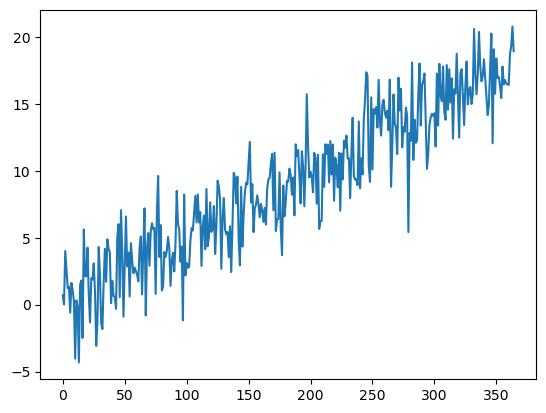

In [227]:
plt.plot(ser)

X = bei[['bei_de']].copy()

X.pct_change().plot(figsize=(20, 5))

In [232]:
import pytensor.tensor as pt
import pymc as pm
import arviz as az

In [218]:
def create_piecewise_trend(t, t_max, n_changepoints):    
    s = pt.linspace(0, t_max, n_changepoints+2)[1:-1]
    A = (t[:, None] > s)*1
    
    return A, s

def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

def generate_features(t, t_max, n_changepoints=10, n_fourier=6, p=365.25):
    A, s = create_piecewise_trend(t, t_max, n_changepoints)
    X = create_fourier_features(t, n_fourier, p)
    
    return A, s, X

In [238]:
t = np.arange(ser.shape[0])

# This value isn't on the computation graph (it's not computed dynamically from `t_pt`)
t_max = max(t)

with pm.Model() as prophet_model:
    t_pt = pm.MutableData('t', t)

    # We have monthly data, so p=12 leads to annual seasonality
    A, s, X = generate_features(t_pt, t_max, n_changepoints=10, n_fourier=6, p=12)
    
    initial_slope = pm.Normal('initial_slope')
    initial_intercept = pm.Normal('initial_intercept')
    
    # n_changepoint offsets terms to build the peicewise trend
    deltas = pm.Normal('offset_delta', shape=(10,))
        
    intercept = initial_intercept + ((-s * A) * deltas).sum(axis=1)
    slope = initial_slope + (A * deltas).sum(axis=1)
    
    # n_fourier * 2 seasonal coefficients
    beta = pm.Normal('beta', size=12)
    
    mu = pm.Deterministic('mu', intercept + slope * t_pt+ X @ beta)
    sigma = pm.Exponential('sigma', 1)
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=ser, shape=t_pt.shape[0])
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [initial_slope, initial_intercept, offset_delta, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 985 seconds.


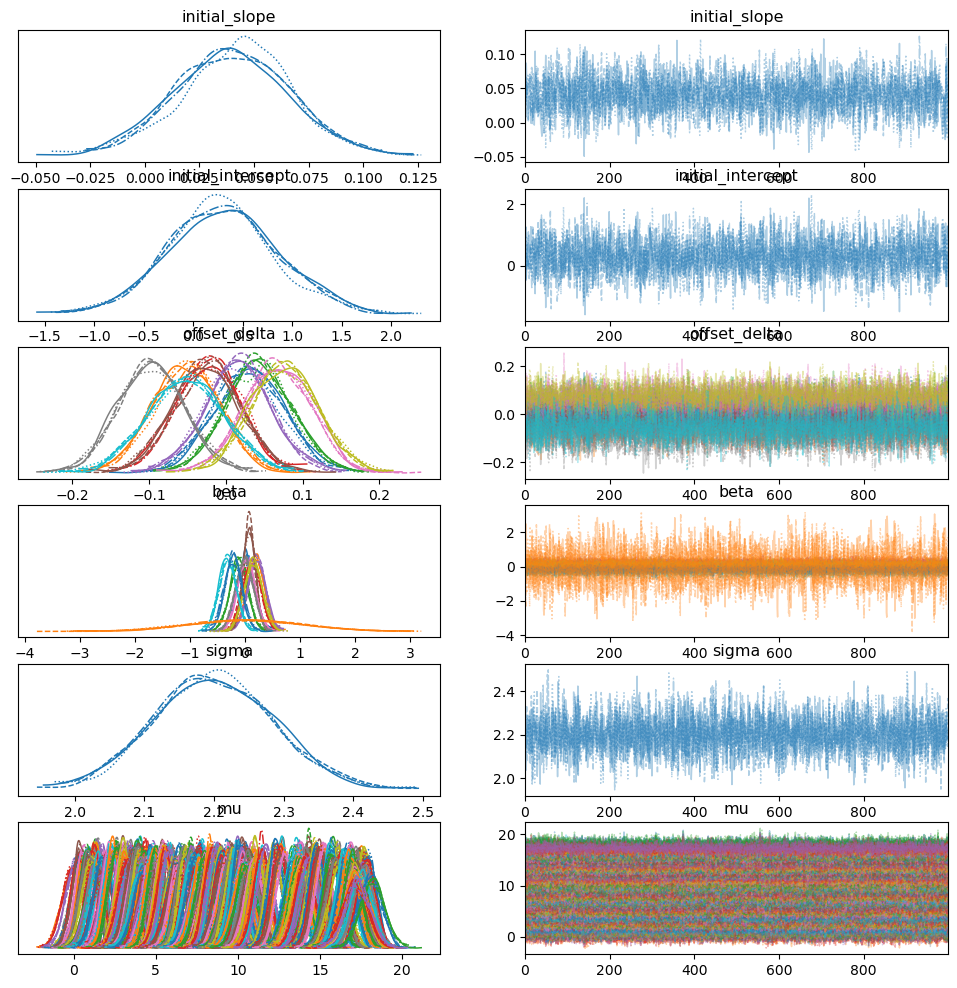

In [241]:
az.plot_trace(idata);

In [242]:
with prophet_model:
    pp = pm.sample_posterior_predictive(idata)

Sampling: [y_hat]


<Axes: xlabel='y_hat / y_hat'>

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_miscell\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


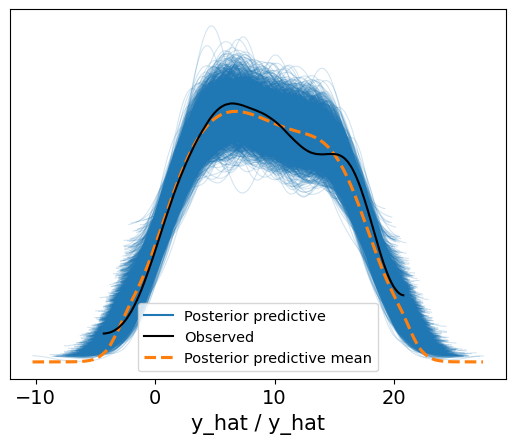

In [243]:
az.plot_ppc(pp)

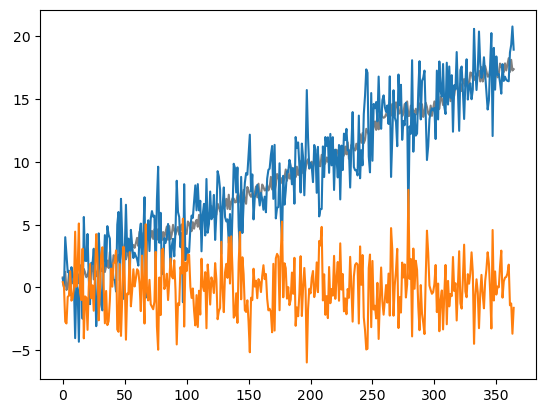

In [278]:
plt.plot(
    pp.posterior_predictive.y_hat[1, np.random.randint(0, 1000, 500)].transpose().mean(axis=1),
    # alpha=.1,
    color='grey',
)
plt.plot(ser)
plt.plot(
    pp.posterior_predictive.y_hat[1, np.random.randint(0, 1000, 100)].transpose().mean(axis=1) - ser
)